In [16]:
# --------------------------------------------------------------
# 0. IMPORTS
# --------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    accuracy_score, classification_report, confusion_matrix
)
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import shap
import joblib
import os
import re  # <-- for cleaning column names

In [17]:
# --------------------------------------------------------------
# 1. LOAD PRE-PROCESSED DATA
# --------------------------------------------------------------
df = pd.read_csv('Dementia_Prediction_preprocessed.csv')
print(f"Loaded: {df.shape}")

assert 'DEMENTED' in df.columns, "Target missing!"
assert 'NACCID' in df.columns, "ID missing!"

Loaded: (195196, 59)


In [18]:
# --------------------------------------------------------------
# 2. CLEAN COLUMN NAMES (CRITICAL FIX)
# --------------------------------------------------------------
def clean_col_name(col):
    """Remove characters that XGBoost cannot handle in feature names."""
    col = str(col)
    col = re.sub(r'[\[\]<>]', '_', col)   # replace [, ], <, > with _
    col = re.sub(r'\s+', '_', col)        # spaces → _
    col = re.sub(r'_+', '_', col)         # collapse multiple _
    col = col.strip('_')
    return col

# Apply to all columns
df.columns = [clean_col_name(c) for c in df.columns]

print("Column names cleaned (example):")
print(df.columns[:10].tolist())

Column names cleaned (example):
['BIRTHMO', 'BIRTHYR', 'HISPANIC', 'HISPOR', 'RACE', 'RACESEC', 'RACETER', 'PRIMLANG', 'EDUC', 'MARISTAT']


In [19]:
# --------------------------------------------------------------
# 3. DEFINE FEATURES & TARGET
# --------------------------------------------------------------
target = 'DEMENTED'
id_col = 'NACCID'
feature_cols = [c for c in df.columns if c not in [target, id_col]]

X_raw = df[feature_cols].copy()
y = df[target].copy()
ids = df[id_col].copy()

print(f"Features: {len(feature_cols)} | Samples: {X_raw.shape[0]}")

Features: 57 | Samples: 195196


In [23]:
# --------------------------------------------------------------
# 4. ONE-HOT ENCODE CATEGORICALS
# --------------------------------------------------------------
cat_cols = X_raw.select_dtypes(include='object').columns.tolist()
X = pd.get_dummies(X_raw, columns=cat_cols, drop_first=True, dtype=int)

# --- CLEAN AFTER DUMMIES ---
import re
def clean_feature_name(col):
    col = str(col)
    col = re.sub(r'[\[\]<>,]', '_', col)
    col = re.sub(r'\s+', '_', col)
    col = re.sub(r'_+', '_', col)
    return col.strip('_')

X.columns = [clean_feature_name(c) for c in X.columns]
print(f"Final features: {X.shape[1]} | Cleaned names")

Final features: 58 | Cleaned names


In [24]:
# --------------------------------------------------------------
# 5. TRAIN-TEST SPLIT
# --------------------------------------------------------------
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, ids, test_size=0.20, stratify=y, random_state=42
)

print(f"Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")
print(f"Class balance (train): {y_train.mean():.3f}")

Train: 156156 | Test: 39040
Class balance (train): 0.295


In [25]:
# --------------------------------------------------------------
# 6. HYPEROPT BAYESIAN OPTIMIZATION (FIXED)
# --------------------------------------------------------------
def objective(params):
    model = xgb.XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        min_child_weight=int(params['min_child_weight']),
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        eval_metric='auc',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1,
        tree_method='hist'
    )
    model.fit(X_train, y_train)
    probas = model.predict_proba(X_test)[:, 1]
    return {'loss': -roc_auc_score(y_test, probas), 'status': STATUS_OK}

space = {
    'n_estimators': hp.quniform('n_estimators', 100, 800, 50),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30,
            rstate=np.random.default_rng(42), verbose=0)
print("Best params:", best)

e:\Projects\ModelX-Training\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:20:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\Projects\ModelX-Training\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:20:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\Projects\ModelX-Training\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:20:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\Projects\ModelX-Training\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:20:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encode

Best params: {'colsample_bytree': np.float64(0.6116399224205231), 'gamma': np.float64(0.7624066316081712), 'learning_rate': np.float64(0.0528768916968907), 'max_depth': np.float64(10.0), 'min_child_weight': np.float64(5.0), 'n_estimators': np.float64(700.0), 'reg_alpha': np.float64(0.18592843931206848), 'reg_lambda': np.float64(0.3334538887308189), 'subsample': np.float64(0.8415097158619497)}


In [26]:
# --------------------------------------------------------------
# 7. TRAIN FINAL MODEL
# --------------------------------------------------------------
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

final_model = xgb.XGBClassifier(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    learning_rate=best['learning_rate'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    min_child_weight=int(best['min_child_weight']),
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)

final_model.fit(X_train, y_train)

e:\Projects\ModelX-Training\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:26:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,np.float64(0.6116399224205231)
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'



=== FINAL PERFORMANCE ===
AUC-ROC: 0.9465 | AUC-PR: 0.9062 | F1: 0.8390 | Acc: 0.9038


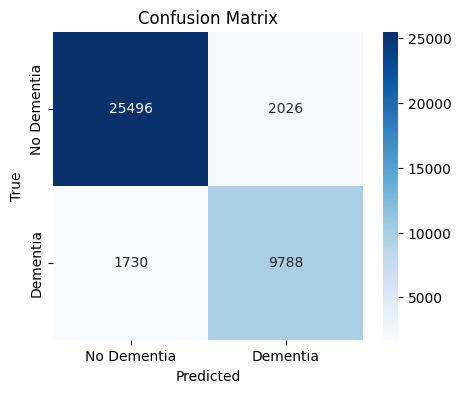

In [27]:
# --------------------------------------------------------------
# 8. EVALUATION
# --------------------------------------------------------------
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print(f"\n=== FINAL PERFORMANCE ===")
print(f"AUC-ROC: {auc:.4f} | AUC-PR: {pr_auc:.4f} | F1: {f1:.4f} | Acc: {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Dementia', 'Dementia'],
            yticklabels=['No Dementia', 'Dementia'])
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

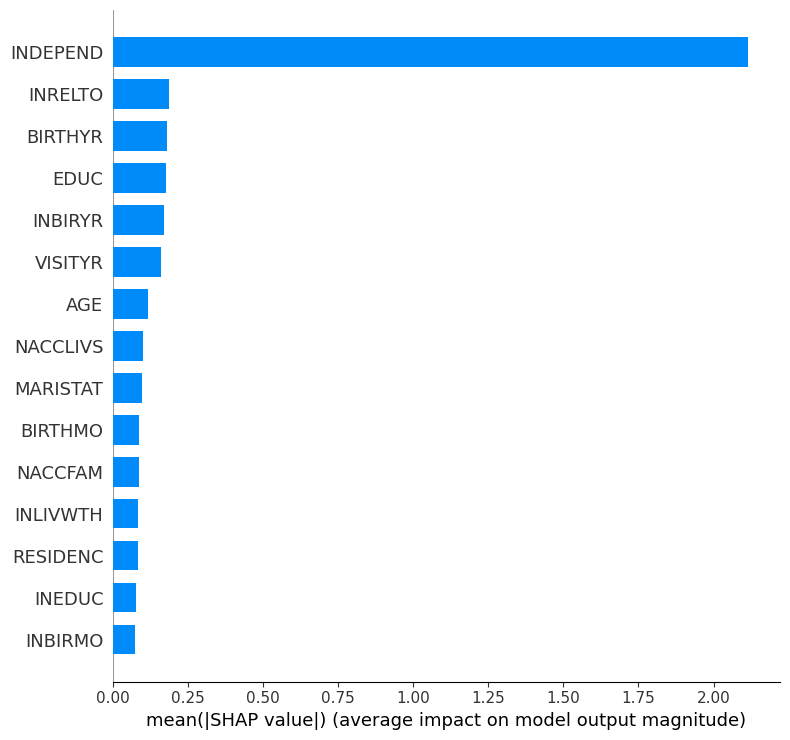

<Figure size 640x480 with 0 Axes>

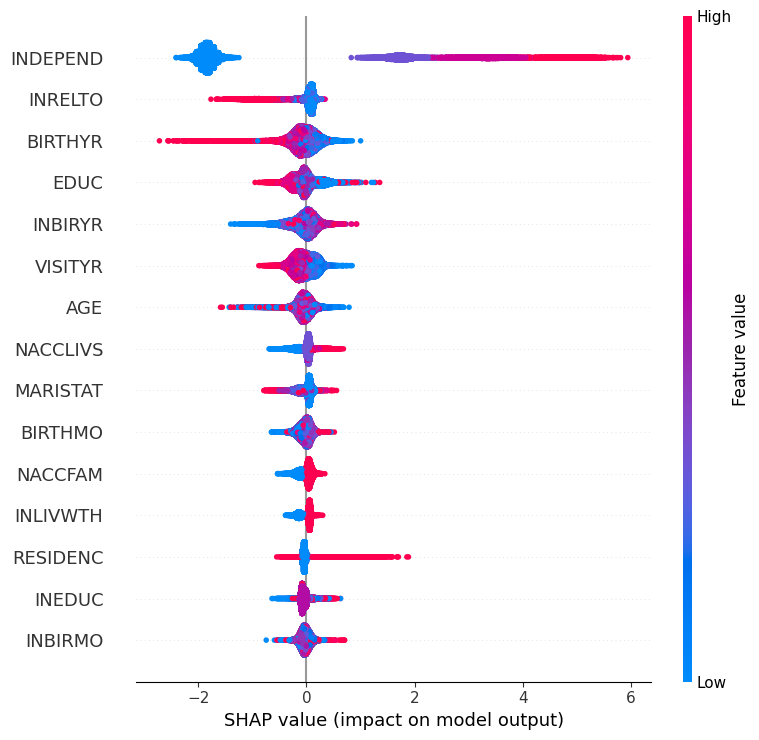

<Figure size 640x480 with 0 Axes>

In [28]:
# --------------------------------------------------------------
# 9. SHAP EXPLAINABILITY
# --------------------------------------------------------------
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

# Global importance
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15)
plt.savefig('shap_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# Beeswarm
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test, max_display=15)
plt.savefig('shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()

In [29]:
# --------------------------------------------------------------
# 10. SAVE ARTIFACTS
# --------------------------------------------------------------
os.makedirs('model_artifacts', exist_ok=True)

joblib.dump(final_model, 'model_artifacts/xgb_model.pkl')
pd.DataFrame({
    'NACCID': id_test,
    'true': y_test,
    'pred_proba': y_pred_proba,
    'pred_label': y_pred
}).to_csv('model_artifacts/test_predictions.csv', index=False)

pd.Series(X.columns).to_csv('model_artifacts/feature_names.csv', index=False)

print("\nAll done! Model & plots saved.")


All done! Model & plots saved.
